In [9]:
# https://www.jeonghyunjin.com/SpaceWeatherNow/Scales

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astropy.units as u
from sunpy.timeseries import TimeSeries
from sunpy.time import parse_time

<class 'sunpy.timeseries.sources.goes.XRSTimeSeries'>


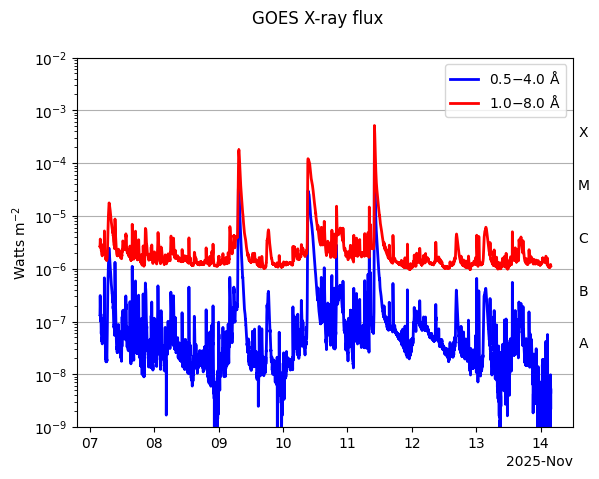

In [11]:
goes_data = pd.read_json(
    'https://services.swpc.noaa.gov/json/goes/primary/xrays-7-day.json'
)
goes_data = goes_data.pivot(
    index='time_tag',
    columns='energy',
    values='flux'
)
goes_data = goes_data.rename(
    columns={
        '0.05-0.4nm': 'xrsa',
        '0.1-0.8nm': 'xrsb'
    }
)
goes_data.index = parse_time(goes_data.index).datetime
meta = dict(
    {"instrument": "GOES X-ray sensor", "measurements": "primary", "type": "quicklook"}
)
units = dict([("xrsa", u.W / u.m ** 2), ("xrsb", u.W / u.m ** 2)])
goes_ts = TimeSeries(goes_data, meta, units, source="xrs")
print(type(goes_ts))
goes_ts.peek()

In [12]:
flare_events = pd.read_json(
    "https://services.swpc.noaa.gov/json/goes/primary/xray-flares-7-day.json"
)

In [13]:
if len(flare_events) > 0:
    largest_flares = flare_events.sort_values('max_xrlong', ascending=False)[:5]
else:
    largest_flares = []

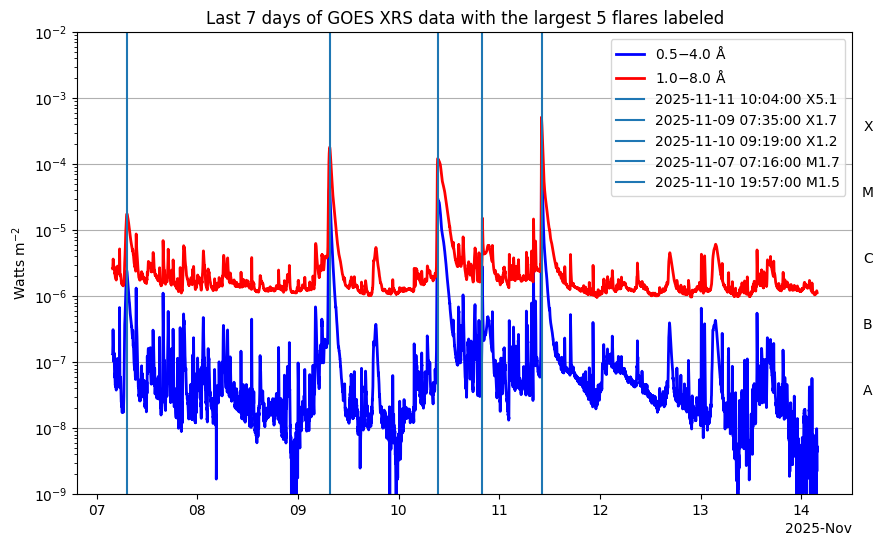

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
goes_ts.plot(axes=ax)
if len(largest_flares) > 0:
    for _, this_flare in largest_flares.iterrows():
        peak_time = parse_time(this_flare["max_time"])
        ax.axvline(peak_time.datetime, label=f'{peak_time.datetime} {this_flare["max_class"]}')
ax.legend()
ax.set_title(f"Last 7 days of GOES XRS data with the largest {len(largest_flares)} flares labeled")
plt.show()

In [15]:
goes_data = pd.read_json(
    'https://services.swpc.noaa.gov/json/goes/primary/xrays-7-day.json'
)
sat = goes_data['satellite'].unique()
if len(sat) == 1:
    sat = sat[0]
    print(f"GOES satellite: {sat}")
else:
    print(f"Multiple GOES satellites found: {sat}")
goes_data = goes_data.pivot(
    index='time_tag',
    columns='energy',
    values='flux'
)
goes_data.index = pd.to_datetime(
    goes_data.index,
    format='%Y-%m-%dT%H:%M:%SZ'
)

GOES satellite: 18


Text(0.97, 0.0001, 'X')

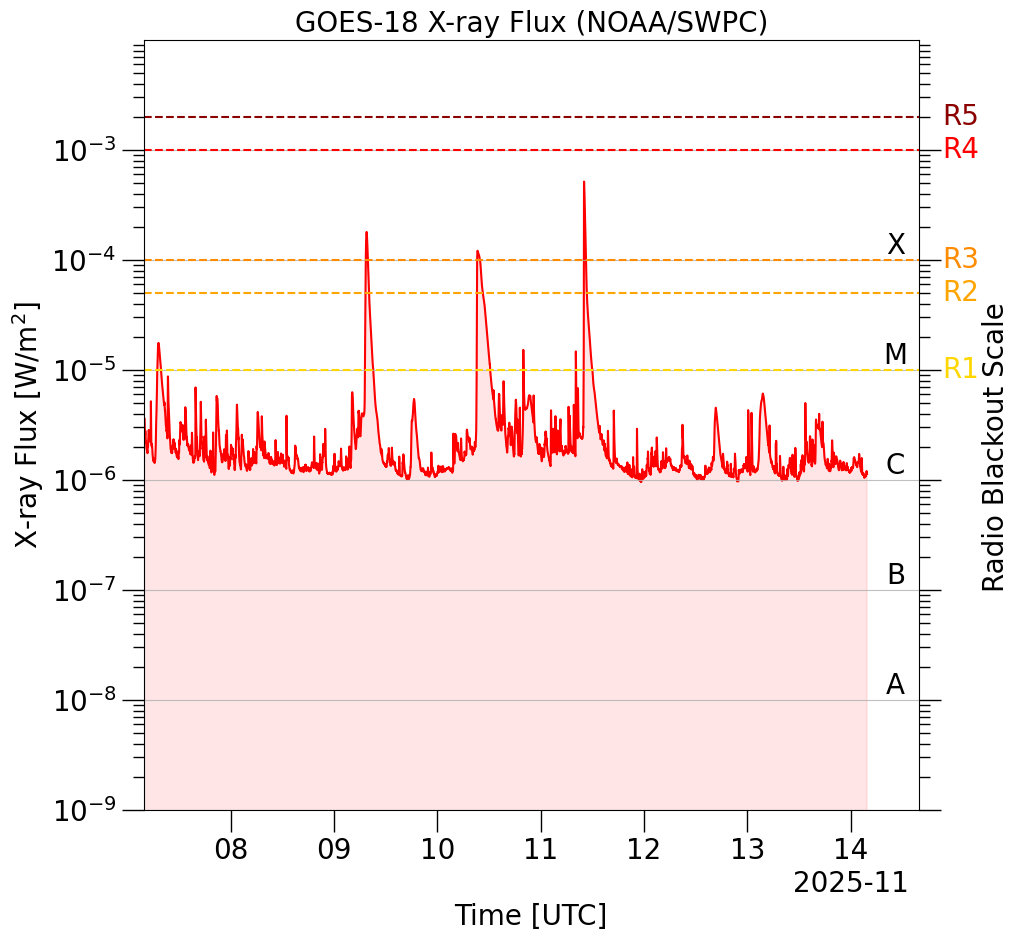

In [38]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f'GOES-{sat} X-ray Flux (NOAA/SWPC)', fontsize=20)
ax.plot(
    goes_data.index,
    goes_data['0.1-0.8nm'],
    label='Long (1.0 - 8.0 Å)',
    color='red',
    zorder=1,
)
ax.fill_between(
    goes_data.index,
    goes_data['0.1-0.8nm'],
    color='red',
    alpha=0.1,
    zorder=1,
)
# ax.plot(
#     goes_data.index,
#     goes_data['0.05-0.4nm'],
#     label='Short (0.5 - 4.0 Å)',
#     color='blue',
#     zorder=0,
# )
ax.set_ylim(1e-9, 1e-2)
ax.set_yscale('log')
ax.set_ylabel('X-ray Flux [W/m$^2$]', fontsize=20)
ax.set_xlabel('Time [UTC]', fontsize=20)
ax.set_yticks(np.logspace(-9, -3, num=7))
ax.tick_params(axis='both', which='major', labelsize=20, length=16, width=1)
ax.tick_params(axis='both', which='minor', labelsize=20, length=8, width=1)
ax.tick_params(axis='y', which='both', right=True)
# for label in ax.get_xticklabels():
#     label.set_rotation(30)
#     label.set_ha('right')

def custom_formatter(x, pos):
    ticks = ax.get_xticks()
    if len(ticks) == 0:
        return ""

    # 마지막 tick과 같은지 판단 (float 비교 → 허용 오차 사용)
    if abs(x - ticks[-1]) < 1e-6:
        dt = mdates.num2date(x)
        ym = dt.strftime("%Y-%m")
        d = dt.strftime("%d")
        return f"{d}\n{ym}"  # 마지막 tick → YYYY-MM-DD
    
    # 기본 tick → day만
    dt = mdates.num2date(x)
    return dt.strftime("%d")

ax.xaxis.set_major_formatter(custom_formatter)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
last_tick = ax.get_xticks()[-1]
# last_dt = mdates.num2date(last_tick)
# last_label = last_dt.strftime("%Y-%m")
last_tick_dt = mdates.num2date(last_tick)
last_label = last_tick_dt.strftime("%Y-%m-%d")
ax.grid(True, which='major', axis='y', linestyle='-', alpha=0.8)

ax.axhline(1e-5, color='gold', linestyle='--', zorder=2)
ax.text(1.03, 1e-5, 'R1', color='gold', fontsize=20, va='center', transform=ax.get_yaxis_transform())
ax.axhline(5e-5, color='orange', linestyle='--', zorder=2)
ax.text(1.03, 5e-5, 'R2', color='orange', fontsize=20, va='center', transform=ax.get_yaxis_transform())
ax.axhline(1e-4, color='darkorange', linestyle='--', zorder=2)
ax.text(1.03, 1e-4, 'R3', color='darkorange', fontsize=20, va='center', transform=ax.get_yaxis_transform())
ax.axhline(1e-3, color='red', linestyle='--', zorder=2)
ax.text(1.03, 1e-3, 'R4', color='red', fontsize=20, va='center', transform=ax.get_yaxis_transform())
ax.axhline(2e-3, color='darkred', linestyle='--', zorder=2)
ax.text(1.03, 2e-3, 'R5', color='darkred', fontsize=20, va='center', transform=ax.get_yaxis_transform())
ax.set_xlim(goes_data.index.min(), goes_data.index.max()+pd.Timedelta(days=0.5))
ax.text(1.1, 2e-6, 'Radio Blackout Scale', rotation=90, fontsize=20,
        va='center', ha='center', transform=ax.get_yaxis_transform())
ax.text(0.97, 1e-8, 'A', fontsize=20, va='bottom', ha='center', transform=ax.get_yaxis_transform(), 
        color='black')
ax.text(0.97, 1e-7, 'B', fontsize=20, va='bottom', ha='center', transform=ax.get_yaxis_transform(), 
        color='black')
ax.text(0.97, 1e-6, 'C', fontsize=20, va='bottom', ha='center', transform=ax.get_yaxis_transform(), 
        color='black')
ax.text(0.97, 1e-5, 'M', fontsize=20, va='bottom', ha='center', transform=ax.get_yaxis_transform(), 
        color='black')
ax.text(0.97, 1e-4, 'X', fontsize=20, va='bottom', ha='center', transform=ax.get_yaxis_transform(), 
        color='black')

# ax.text(
#     last_tick,                       # x 위치
#     ax.get_ylim()[0],                # y: x축 아래
#     last_label,
#     ha='center', va='top',
#     fontsize=10,
#     transform=ax.get_xaxis_transform(),  # x축 좌표계에서 y만 데이터 좌표계
#     # y=-0.3                           # x축 아래로 조금 내리기
# )